# TabPFN Intro

TabPFN is a foundation model for tabular data, which uses in-context learning to do solve classification and regression tasks. TabPFN outperforms traditional models like Random Forest, Gradient Boosting for small datasets and raises the state-of-the-art for tabular data! Recently, a major update was released, which includes a new architecture and an updated API.

For more information about TabPFN, check the [github repository](https://github.com/PriorLabs/TabPFN) and the associated papers ([TabPFN](https://openreview.net/forum?id=eu9fVjVasr4), [TabPFNv2](https://www.nature.com/articles/s41586-024-08328-6)).

In this notebook tutorial we demonstrate ho to use TabPFN on some simple example datasets.

## Installation

In [1]:
# Install sklearn
!pip install scikit-learn==1.5.2

# Install TabPFN
!pip install tabpfn

# Install Baselines
!pip install catboost xgboost

# Install example datasets
#!pip install datasets

#Install TabPFN extensions
!git clone https://github.com/PriorLabs/tabpfn-community
!pip install -e tabpfn-community[post_hoc_ensembles,interpretability,hpo]

# Restart kernel or session to use the installed extensions!

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 37.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.5/105.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.metrics import (
    accuracy_score,
    mean_absolute_error,
    mean_squared_error,
    root_mean_squared_error,
    r2_score,
    roc_auc_score,
)
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

## TabPFN Classification Example

For our first example, we will use the client to predict on [toy data from scikit-learn](https://scikit-learn.org/stable/datasets/toy_dataset.html).

In [4]:
#data = datasets.fetch_openml(name='parkinsons') # other: 'cholesterol', 'diabtes'
data = datasets.load_breast_cancer()
#data = datasets.load_iris()
feature_names = data.feature_names
target_names = data.target_names
print('Feature names:', feature_names)
print('Target names:', target_names)
print('Training data shape:', data.data.shape)


Feature names: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
Target names: ['malignant' 'benign']
Training data shape: (569, 30)


### Split in Train and Test Sample

In order to use TabPFN, we need to split the data into a training and testing set.

In [5]:
x_train, x_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.5, random_state=42)
print("Train data shape: ", x_train.shape, y_train.shape)
print("Test data shape: ", x_test.shape, y_test.shape)

Train data shape:  (284, 30) (284,)
Test data shape:  (285, 30) (285,)


### Fit TabPFN

Now that we have the data, we can fit TabPFN to the training data for classification.

In [6]:
# Check the argument options of tabpfn.TabPFNRegressor
from tabpfn import TabPFNClassifier
print(TabPFNClassifier.__init__.__doc__)

A TabPFN interface for classification.

        Args:
            n_estimators:
                The number of estimators in the TabPFN ensemble. We aggregate the
                 predictions of `n_estimators`-many forward passes of TabPFN. Each
                 forward pass has (slightly) different input data. Think of this as an
                 ensemble of `n_estimators`-many "prompts" of the input data.

            categorical_features_indices:
                The indices of the columns that are suggested to be treated as
                categorical. If `None`, the model will infer the categorical columns.
                If provided, we might ignore some of the suggestion to better fit the
                data seen during pre-training.

                !!! note
                    The indices are 0-based and should represent the data passed to
                    `.fit()`. If the data changes between the initializations of the
                    model and the `.fit()`, consider s

In [7]:
clf = TabPFNClassifier()
clf.fit(x_train, y_train)

/usr/local/lib/python3.11/dist-packages/tabpfn/base.py:88: UserWarning: Downloading model to /root/.cache/tabpfn/tabpfn-v2-classifier.ckpt.
  model, _, config_ = load_model_criterion_config(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tabpfn-v2-classifier.ckpt:   0%|          | 0.00/29.0M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

TabPFNClassifier()

### Evaluation

In [8]:
# Predict labels
predictions = clf.predict(x_test)
print("Accuracy", accuracy_score(y_test, predictions))

Accuracy 0.9824561403508771


In [9]:
# Predict probabilities
prediction_probabilities = clf.predict_proba(x_test) # shape (n_samples, n_classes)
print("ROC AUC:", roc_auc_score(y_test, prediction_probabilities[:, 1]))

ROC AUC: 0.9981447124304268


### Comparison to Random Forest Classifier

In [10]:
clf_rf = RandomForestClassifier()
clf_rf.fit(x_train, y_train)
predictions_rf = clf_rf.predict(x_test)
print("Accuracy RF:", accuracy_score(y_test, predictions_rf))
print("ROC AUC RF:", roc_auc_score(y_test, clf_rf.predict_proba(x_test)[:, 1]))

Accuracy RF: 0.9614035087719298
ROC AUC RF: 0.9962348575793954


### Extra: Compare with more models

Compare different machine learning models by training each one multiple times
on different parts of the data and averaging their performance scores for a
more reliable performance estimate

In [11]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, CatBoostRegressor

Text(0.5, 1.0, 'Model Comparison - 5-fold Cross-validation')

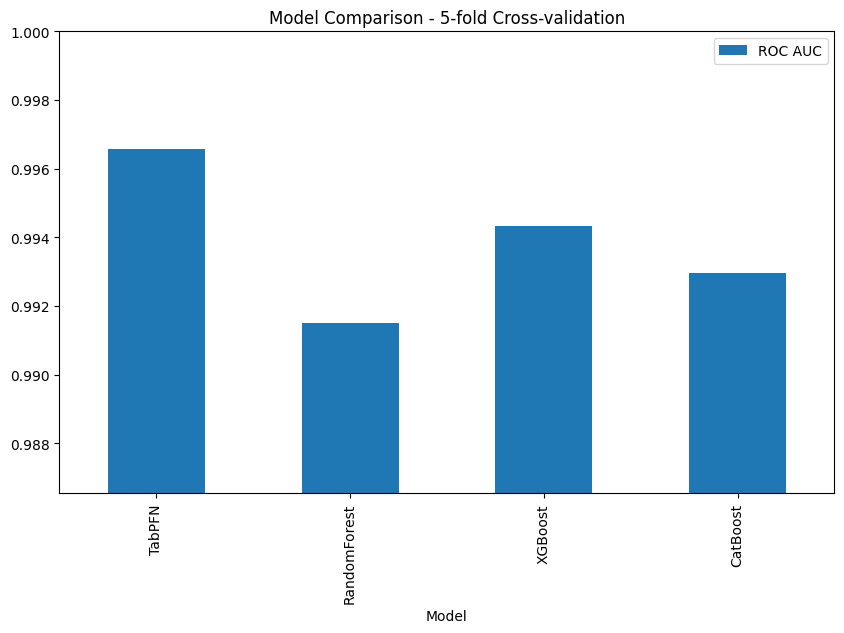

In [12]:
# Define models
models = [
    ('TabPFN', TabPFNClassifier(random_state=42)),
    ('RandomForest', RandomForestClassifier(random_state=42)),
    ('XGBoost', XGBClassifier(random_state=42)),
    ('CatBoost', CatBoostClassifier(random_state=42, verbose=0))
]

# Calculate scores
scoring = 'roc_auc_ovr' if len(np.unique(data.target)) > 2 else 'roc_auc'
scores = {name: cross_val_score(model, data.data, data.target, cv=5, scoring=scoring, n_jobs=1, verbose=1).mean()
          for name, model in models}

# Plot results
df = pd.DataFrame(list(scores.items()), columns=['Model', 'ROC AUC'])
ax = df.plot(x='Model', y='ROC AUC', kind='bar', figsize=(10, 6))
ax.set_ylim(df['ROC AUC'].min() * 0.995, min(1.0, df['ROC AUC'].max() * 1.005))
ax.set_title('Model Comparison - 5-fold Cross-validation')

### Extra: Improve TabPFN with Post Hoc Ensembles (PHE)

TabPFN (default) uses a fixed ensemble with pre-defined settings, while TabPFN with PHE automatically combines TabPFN models with PHE and tunes their hyperparameters, potentially leading to improved performance

In [6]:
from tabpfn_extensions.post_hoc_ensembles.sklearn_interface import AutoTabPFNClassifier

clf = AutoTabPFNClassifier(max_time=30) # runs for 30 seconds, longer ensembling time leads to better results
clf.fit(x_train, y_train)
prediction_probabilities = clf.predict_proba(x_test)
predictions = np.argmax(prediction_probabilities, axis=-1)

print("ROC AUC:", roc_auc_score(y_test, prediction_probabilities[:, 1]))
print("Accuracy", accuracy_score(y_test, predictions))

/usr/local/lib/python3.11/dist-packages/tabpfn/base.py:88: UserWarning: Downloading model to /content/tabpfn-community/src/tabpfn_extensions/hpo/hpo_models/tabpfn-v2-classifier-od3j1g5m.ckpt.
  model, _, config_ = load_model_criterion_config(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tabpfn-v2-classifier-od3j1g5m.ckpt:   0%|          | 0.00/29.0M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

INFO:tabpfn_extensions.post_hoc_ensembles.greedy_weighted_ensemble:Order of selections: [1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
INFO:tabpfn_extensions.post_hoc_ensembles.greedy_weighted_ensemble:Val loss over iterations: [-0.9906015037593985, -0.9906015037593985, -0.9906015037593985, -0.9906015037593985, -0.9906015037593985, -0.9906015037593985, -0.9906015037593985, -0.9906015037593985, -0.9906015037593985, -0.9906015037593985, -0.9906015037593985, -0.9906015037593985, -0.9906015037593985, -0.9906015037593985, -0.9906015037593985, -0.9906015037593985, -0.9906015037593985, -0.9906015037593985, -0.9906015037593985, -0.9906015037593985, -0.9906015037593985, -0.9906015037593985, -0.9906015037593985, -0.9906015037593985, -0.9906015037593985]
INFO:tabpfn_extensions.post_hoc_ensembles.greedy_weighted_ensemble:Model losses: [-0.9906015 -0.9906015]
INFO:tabpfn_extensions.post_hoc_ensembles.greedy_weighted_ensemble:Best weights: [0. 1.]


ROC AUC: 0.9983084142748009
Accuracy 0.9719298245614035


## TabPFN Regression Example

Here we use the California housing dataset and make predictions for the house price using TabPFN.
For more details on real-world dataset see https://scikit-learn.org/stable/datasets/real_world.html

### Load Dataset Example

In [7]:
data = datasets.fetch_california_housing()
feature_names = data.feature_names
target_names = data.target_names
print('Feature names:', feature_names)
print('Target names:', target_names)
print('Training data shape:', data.data.shape)


Feature names: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Target names: ['MedHouseVal']
Training data shape: (20640, 8)


### Split in Train and Test Sample

In order to use TabPFN, we need to split the data into a training and testing set. Note, that TabPFN works best for small sized datasets (less than 10k samples). On CPU, we can only use a very small number of training data points to fit the model. If you have a GPU, feel free to increase the number of samples.

In [8]:
x_train, x_test, y_train, y_test = train_test_split(data.data, data.target, train_size=500, test_size= 500, random_state=42)
print("Train data shape: ", x_train.shape, y_train.shape)
print("Test data shape: ", x_test.shape, y_test.shape)

Train data shape:  (500, 8) (500,)
Test data shape:  (500, 8) (500,)


### Fit TabPFN

Now that we have the data, we can fit TabPFN to the training data and make it ready for predictions.

In [9]:
# Check the argument options of tabpfn.TabPFNRegressor
from tabpfn import TabPFNRegressor
print(TabPFNRegressor.__init__.__doc__)

A TabPFN interface for regression.

        Args:
            n_estimators:
                The number of estimators in the TabPFN ensemble. We aggregate the
                predictions of `n_estimators`-many forward passes of TabPFN.
                Each forward pass has (slightly) different input data. Think of this
                as an ensemble of `n_estimators`-many "prompts" of the input data.

            categorical_features_indices:
                The indices of the columns that are suggested to be treated as
                categorical. If `None`, the model will infer the categorical columns.
                If provided, we might ignore some of the suggestion to better fit the
                data seen during pre-training.

                !!! note
                    The indices are 0-based and should represent the data passed to
                    `.fit()`. If the data changes between the initializations of the
                    model and the `.fit()`, consider setting 

In [10]:
model = TabPFNRegressor()
model.fit(x_train, y_train)

/usr/local/lib/python3.11/dist-packages/tabpfn/base.py:100: UserWarning: Downloading model to /root/.cache/tabpfn/tabpfn-v2-regressor.ckpt.
  model, bardist, config_ = load_model_criterion_config(


tabpfn-v2-regressor.ckpt:   0%|          | 0.00/44.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

TabPFNRegressor()

### Evaluate Model Predictions

In [11]:
predictions = model.predict(x_test)
r2 = r2_score(y_test, predictions)
print("R2: ", r2)

R2:  0.8046563805743472


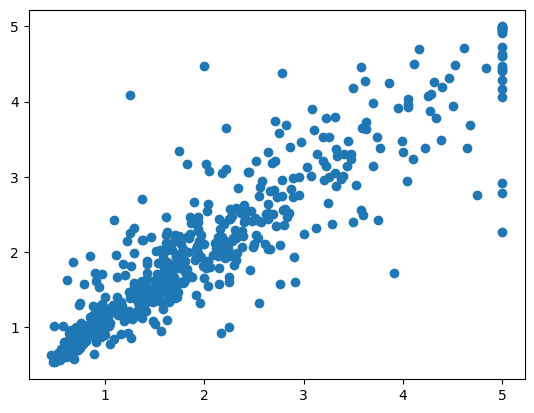

In [12]:
# plot prediction vs true value
plt.scatter(y_test, predictions)

### Predictive posterior

In [13]:
# print arguments for model.predict
print(model.predict.__doc__)

Predict the target variable.

        Args:
            X: The input data.
            output_type:
                Determines the type of output to return.

                - If `"mean"`, we return the mean over the predicted distribution.
                - If `"median"`, we return the median over the predicted distribution.
                - If `"mode"`, we return the mode over the predicted distribution.
                - If `"quantiles"`, we return the quantiles of the predicted
                    distribution. The parameter `output_quantiles` determines which
                    quantiles are returned.
                - If `"main"`, we return the all output types above in a dict.
                - If `"full"`, we return the full output of the model, including the
                  logits and the criterion, and all the output types from "main".

            quantiles:
                The quantiles to return if `output="quantiles"`.

                By default, the `[0.1, 0.2, 0.3,

In [14]:
predictions = model.predict(x_test, output_type= 'full')
print(predictions.keys())

dict_keys(['criterion', 'logits', 'mean', 'median', 'mode', 'quantiles'])


In [15]:
quantiles = np.asarray(predictions['quantiles'])
medians = predictions['median']

In [16]:
# Plot function for true vs predictions and quantile distributions
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from matplotlib.colors import LinearSegmentedColormap

def plot_predictions_vs_true(true_values, predictions):
    # Convert to numpy arrays
    true_array = np.array(true_values)
    quantiles_array = np.array(predictions['quantiles'])

    # Get sorting indices
    sort_idx = np.argsort(true_array)

    # Sort arrays
    true_sorted = true_array[sort_idx]
    quantiles_sorted = quantiles_array[:, sort_idx]

    # Get median
    median_idx = len(predictions['quantiles']) // 2
    median_predictions = quantiles_sorted[median_idx]

    # Create figure with space for colorbar
    fig, ax = plt.subplots(figsize=(11, 6))  # Made slightly wider for colorbar

    # Create a smooth interpolation for each sample point
    n_points = 50
    quantile_values = np.linspace(0.1, 0.9, len(predictions['quantiles']))

    # Create alpha values - strongest at 0.5, decreasing towards ends
    smooth_quantiles = np.linspace(0.1, 0.9, n_points)
    alphas = 1 - 2 * np.abs(smooth_quantiles - 0.5)
    alphas = 0.3 * alphas

    # Create custom colormap for colorbar
    colors = [(0, 0, 1, a) for a in alphas]
    custom_cmap = LinearSegmentedColormap.from_list('custom_blues', colors)

    # Create a mappable object for the colorbar
    norm = plt.Normalize(0.1, 0.9)
    sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
    sm.set_array([])

    # Plot density for each true value
    for i in range(len(true_sorted)):
        interp_func = interp1d(quantile_values,
                              quantiles_sorted[:, i],
                              kind='linear',
                              fill_value='extrapolate')

        smooth_predictions = interp_func(smooth_quantiles)

        # Plot vertical lines with varying alpha
        for j in range(len(smooth_quantiles)-1):
            ax.plot([true_sorted[i], true_sorted[i]],
                   [smooth_predictions[j], smooth_predictions[j+1]],
                   color='blue',
                   alpha=alphas[j],
                   linewidth=1)

    # Plot median predictions
    ax.scatter(true_sorted, median_predictions,
              color='darkblue',
              s=20,
              alpha=0.8)

    # Plot perfect prediction line
    min_val = min(min(true_sorted), np.min(quantiles_sorted))
    max_val = max(max(true_sorted), np.max(quantiles_sorted))
    ax.plot([min_val, max_val], [min_val, max_val], 'k--')

    # Add colorbar with specific axes
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Quantile', rotation=270, labelpad=15)
    ticks = np.linspace(0, 1, 5)
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([f'{q:.1f}' for q in np.linspace(0.1, 0.9, 5)])

    # Customize the plot
    ax.set_xlabel('True Values')
    ax.set_ylabel('Predicted Values')
    ax.grid(True, linestyle='--', alpha=0.7)

    return fig, ax

(<Figure size 1100x600 with 2 Axes>,
 <Axes: xlabel='True Values', ylabel='Predicted Values'>)

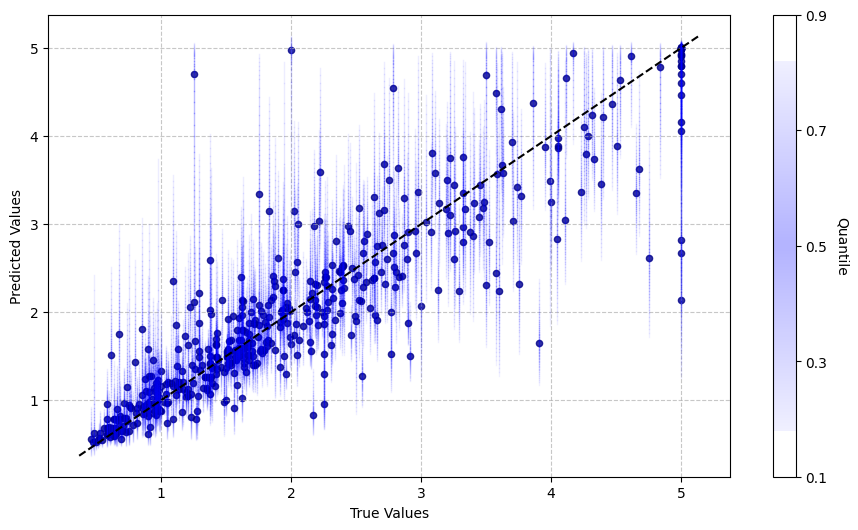

In [17]:
plot_predictions_vs_true(y_test, predictions)

### Comparison to RandomForest Model

In [18]:
rf = RandomForestRegressor()
rf.fit(x_train, y_train)
predictions_rf = rf.predict(x_test)
print("R2 RandomForest", np.round(r2_score(y_test, predictions_rf),4))
print("R2 TabPFN", np.round(r2_score(y_test, predictions['median']),4))

R2 RandomForest 0.7261
R2 TabPFN 0.7928


### Extra: Comparison to more models

Compare different machine learning models by training each one multiple times
on different parts of the data and averaging their performance scores for a
more reliable performance estimate

Text(0.5, 1.0, 'Model Comparison - 5-fold Cross-validation \n (R2)')

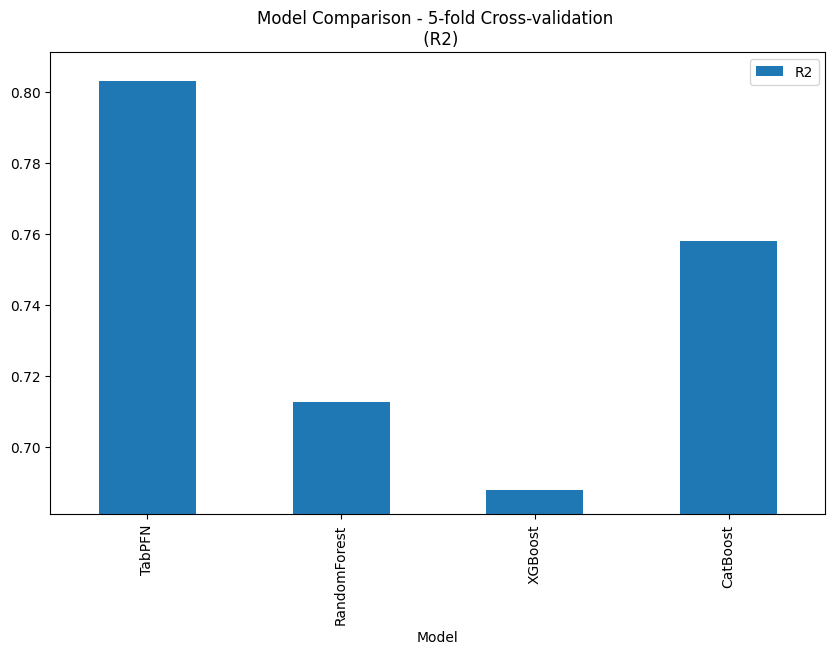

In [45]:
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.model_selection import cross_val_score
# Define models
models = [
    ('TabPFN', TabPFNRegressor(random_state=42)),
    ('RandomForest', RandomForestRegressor(random_state=42)),
    ('XGBoost', XGBRegressor(random_state=42)),
    ('CatBoost', CatBoostRegressor(random_state=42, verbose=0))
]

# Calculate scores
scoring = 'r2'
# reduce sample size to 1000
X, _, y, _ = train_test_split(data.data, data.target, train_size=1000, test_size= 10, random_state=42)
scores = {name: np.mean(cross_val_score(model, X, y, cv=10, scoring=scoring, n_jobs=-1))
          for name, model in models}


# Plot results
df = pd.DataFrame(list(scores.items()), columns=['Model', 'R2'])
ax = df.plot(x='Model', y='R2', kind='bar', figsize=(10, 6))
ax.set_ylim(df['R2'].min() * 0.99, df['R2'].max() * 1.01)
ax.set_title('Model Comparison - 5-fold Cross-validation \n (R2)')